In [3]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import glob

import wfdb

from fastai.tabular.all import *
from tsai.all import *

# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = pathlib.Path(os.path.abspath('')).parents[0]
data_dir = os.path.join(parent_dir, 'data\\')
raw_dir = os.path.join(parent_dir, 'data\\raw\\')
processed_dir = os.path.join(parent_dir, 'data\\processed\\')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(processed_dir)
print(filenames)


def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)


f:\Education\ecg_resp
f:\Education\ecg_resp\data\
f:\Education\ecg_resp\data\processed\
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [4]:
# import preprocessing folders & shared functions

import sys
sys.path.append(os.path.join(parent_dir, 'preprocessing/'))


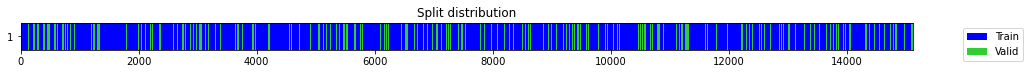

X      - shape: [15121 samples x 1 features x 501 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (15121,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [12097, 3024]  overlap: False


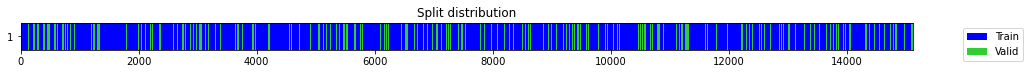

((15121, 1, 501), (15121,))

In [29]:
import self_shared as ss


all_files = glob.glob(os.path.join(processed_dir, "dfg_infant1*.csv"))

dfg = pd.concat((pd.read_csv(f, converters={'resp': lambda x: x.split(',')}) for f in all_files), ignore_index=True)

X, y = ss.gen_numpy(dfg)

X = to3d(X)


splits = get_splits(y, valid_size=.2, stratify=True,
                    random_state=23, shuffle=True)

check_data(X, y, splits)
X.shape, y.shape


In [30]:
import torch

tfms = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms,
                device=torch.device('cuda'),
                 batch_tfms=batch_tfms, bs=128)
dls.one_batch()


(TSTensor(samples:128, vars:1, len:501, device=cuda:0, dtype=torch.float32),
 tensor([146.0446, 151.5152, 146.1864, 154.1756, 159.5745, 150.0000, 154.6392,
         177.1894, 160.8247, 149.6882, 153.1915, 130.4348, 149.6882, 152.5424,
         157.2327, 153.0612, 152.8662, 134.0426, 167.7019, 154.0041, 144.3515,
         141.9355, 152.7495, 156.9038, 152.2199,  78.9474, 161.4907, 144.9580,
         149.6882, 158.8595, 155.2795, 141.3934, 154.1756, 164.3002, 150.3132,
         151.5789, 162.5000, 152.5424, 167.0103, 152.2199, 150.6276, 147.7516,
         168.0498, 156.2500, 153.6885, 146.0446, 146.4968, 148.1481, 160.8247,
         161.4907, 146.6395, 156.3126, 152.5424, 155.9252, 147.2393, 147.2393,
         143.7500, 143.1535, 151.2605, 148.7603, 150.0000, 138.0753, 149.6882,
         145.7490, 156.2500, 108.9744, 154.3210, 156.2500, 146.0177, 142.5620,
         160.8247, 151.2605, 140.5295, 133.7580, 150.3132, 148.3871, 156.9417,
         140.7249, 159.5745, 144.0501, 147.8439, 158.5

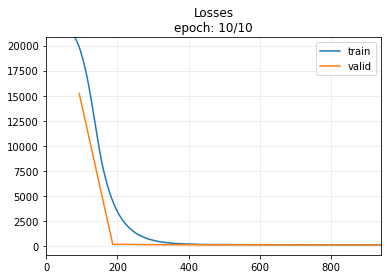

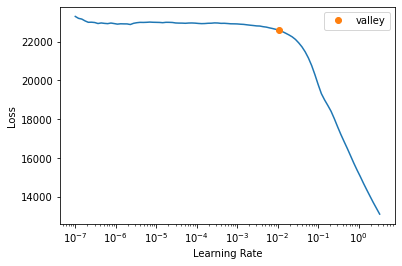

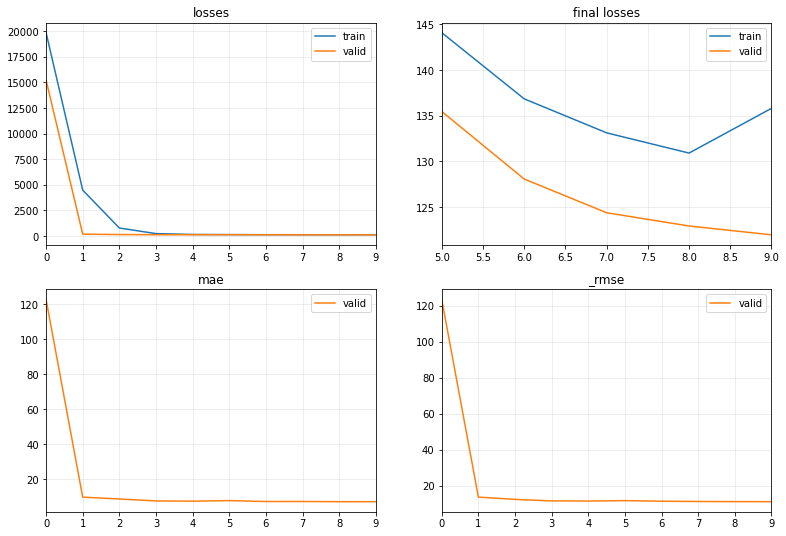

In [41]:
learn = ts_learner(dls, InceptionTime, metrics=[ mae, rmse], cbs=ShowGraph())
learn_rate = learn.lr_find()
learn.fit_one_cycle(10, learn_rate)


In [44]:
# save the model

PATH = Path('../models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

# # delete the variable
# del learn

# load back the model
PATH = Path('../models/Regression.pkl')
model = load_learner(PATH, cpu=False)


In [45]:
# quick check of mse vs last learn mse
from sklearn import metrics as skm
idx = 1
probas, _, preds = model.get_X_preds(X[splits[idx]])
result_mse = skm.mean_squared_error(y[splits[idx]], preds, squared=False)
result_r2 = skm.r2_score(y[splits[idx]], preds)

result_mse, result_r2


(11.044162169541226, 0.196722387518788)